In [ ]:
import os
os.chdir("/content/drive/MyDrive/Tensorflow Advance/Practice/mask_detect")

from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

In [5]:
import zipfile
try:
    os.mkdir('./data')
except:
    pass

In [6]:
fl = zipfile.ZipFile("./face-mask-12k-images-dataset.zip" , "r")
fl.extractall("./data")

In [28]:
test_dir  = "./data/Face Mask Dataset/Test"
train_dir = "./data/Face Mask Dataset/Train"
val_dir   = "./data/Face Mask Dataset/Validation"

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2D , MaxPool2D , BatchNormalization , Flatten , Dropout 
from tensorflow.nn import relu , sigmoid
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
print("Version of tensorflow is : ",tf.__version__)

Version of tensorflow is :  2.3.0


In [18]:
def get_basic_model():
    model = Sequential([
        Conv2D(32 , (3,3) , activation=relu , input_shape=(150 , 150 ,3)),
        MaxPool2D((2,2)),
        BatchNormalization(),
        Conv2D(64 , (3,3) , activation=relu),
        MaxPool2D((2,2)),
        BatchNormalization(),
        Conv2D(128 , (3,3) , activation=relu),
        MaxPool2D((2,2)),
        BatchNormalization(),
        Conv2D(256 , (3,3) , activation=relu),
        MaxPool2D((2,2)),
        BatchNormalization(),
        

        Flatten(),
        Dropout(0.2),
        Dense(256 , activation=relu,kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        Dropout(0.2),
        Dense(256 , activation=relu,kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        Dropout(0.2),
        Dense(1 , activation=sigmoid)
    ])
    model.compile(loss=tf.keras.losses.binary_crossentropy , optimizer='rmsprop' , metrics = "acc")
    return model

In [19]:
basic_model = get_basic_model()

In [17]:
basic_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 74, 74, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)      

In [21]:
train_data_gen = ImageDataGenerator(rescale=(1.0 / 255.0))
test_data_gen  = ImageDataGenerator(rescale=(1.0 / 255.0))

In [22]:
train_data = train_data_gen.flow_from_directory(train_dir ,
                                                batch_size=64 ,
                                                target_size=(150 , 150) ,
                                                class_mode="binary")

test_data = test_data_gen.flow_from_directory(test_dir,
                                              batch_size=64 ,
                                              target_size=(150 , 150) ,
                                              class_mode="binary")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


In [25]:
class MyCallBacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self , epoch , logs={}):
        if logs['val_acc'] >= 0.97:
            print("GET 97% acc on Testing data !!!")
            self.model.stop_training = True

In [26]:
base_model = get_basic_model()
cb = MyCallBacks()
base_history = base_model.fit(train_data ,
                              epochs=10 ,
                              steps_per_epoch=train_data.n//train_data.batch_size ,
                              validation_data=test_data ,
                              validation_steps=test_data.n // test_data.batch_size,
                              callbacks=[cb])

Epoch 1/10
156/156 [==============================] - 31s 200ms/step - loss: 0.3715 - acc: 0.9482 - val_loss: 1.8395 - val_acc: 0.6187
Epoch 2/10
156/156 [==============================] - 31s 197ms/step - loss: 0.1938 - acc: 0.9806 - val_loss: 0.2567 - val_acc: 0.9552
Epoch 3/10
156/156 [==============================] - 31s 196ms/step - loss: 0.1530 - acc: 0.9858 - val_loss: 0.2742 - val_acc: 0.9677
Epoch 4/10
156/156 [==============================] - 31s 198ms/step - loss: 0.1163 - acc: 0.9867 - val_loss: 0.1245 - val_acc: 0.9885


In [29]:
val_data_gen = ImageDataGenerator(rescale=(1.0 / 255.0))
val_data     = val_data_gen.flow_from_directory(val_dir,
                                              batch_size=64 ,
                                              target_size=(150 , 150) ,
                                              class_mode="binary")

Found 800 images belonging to 2 classes.


In [33]:
loss , acc =base_model.evaluate(val_data)
print("ACCURECY OF THE VALIDATION DATA IS : %.3f %% !!!"%(acc * 100))

13/13 [==============================] - 2s 148ms/step - loss: 0.1038 - acc: 0.9900
ACCURECY OF THE VALIDATION DATA IS : 99.000 % !!!


In [49]:
class_label = {}
for k , v in train_data.class_indices.items():
    class_label[v] = k
def predict(model , url , file_type = ".jpg"):
    name = "img"+time.asctime()+file_type
    img = tf.keras.utils.get_file(name , url)
    img = tf.keras.preprocessing.image.load_img(img , target_size=(150 , 150))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0
    plt.imshow(img)
    p = model.predict_classes(img[tf.newaxis , ])[0][0]
    plt.title(class_label[p])

524288/517179 [==============================] - 0s 0us/step


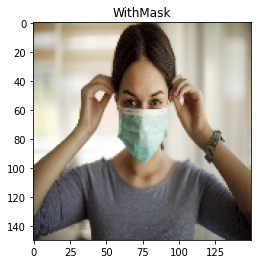

In [50]:
url = 'https://s3.amazonaws.com/cms.ipressroom.com/338/files/20205/5ef4a06b2cfac20a22a6b23d_Woman+wearing+a+mask/Woman+wearing+a+mask_295f0f35-e37d-4adc-b957-44e9d640194a-prv.jpg'
predict(base_model , url)

73728/71949 [==============================] - 0s 0us/step


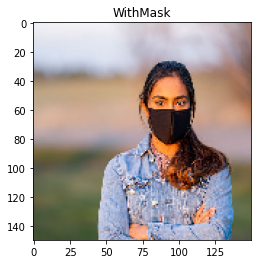

In [51]:
url = 'https://www.henryford.com/-/media/henry-ford-blog/images/mobile-interior-banner-images/2020/07/mask-myths.jpg'
predict(base_model , url)

139264/132460 [===============================] - 0s 0us/step


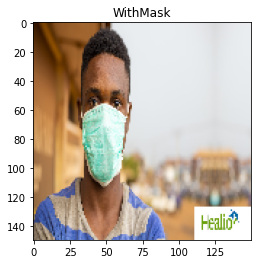

In [52]:
url = 'https://www.healio.com/~/media/slack-news/fm_im/misc/infographics/2020/august/pc0820bailey_graphic_02.jpg?h=630&w=1200&la=en&hash=9121A951DD672C8ADE3B1D0F7D4D39CB'
predict(base_model , url)

16384/14890 [=================================] - 0s 0us/step


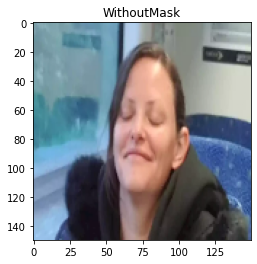

In [57]:
url = 'https://headtopics.com/images/2020/9/1/newscomauhq/man-brags-about-riding-public-transport-without-mask-1300738921970765825.webp'
predict(base_model , url)

106496/103320 [==============================] - 0s 0us/step


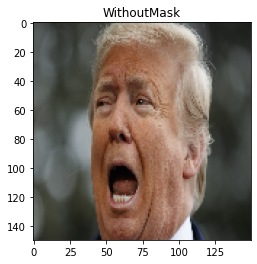

In [65]:
url = 'https://americanindependent.com/wp-content/uploads/2019/01/AP_19014569142266-1068x721.jpg'
predict(base_model , url)

81920/77772 [===============================] - 0s 0us/step


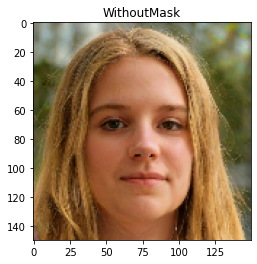

In [67]:
url = 'https://mk0qomafemocnned3wjh.kinstacdn.com/wp-content/uploads/2019/02/AI-thispersondoesnotexist.jpg'
predict(base_model , url)

40960/40583 [==============================] - 0s 9us/step


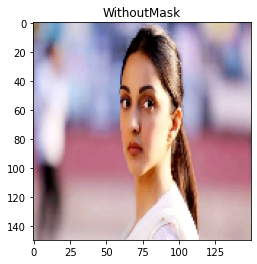

In [71]:
url = 'https://cdn.dnaindia.com/sites/default/files/styles/full/public/2019/12/20/885880-kiaraadvani-kabirsingh.jpg'
predict(base_model , url)

57344/51361 [=================================] - 0s 1us/step


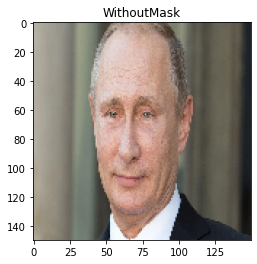

In [77]:
url = "https://secure.i.telegraph.co.uk/multimedia/archive/03491/Vladimir_Putin_1_3491835k.jpg"
predict(base_model , url)

24576/19728 [=====================================] - 0s 0us/step


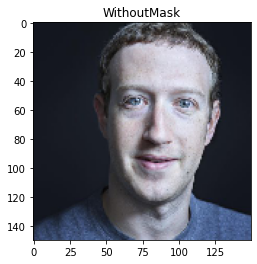

In [81]:
url = "https://thumbor.forbes.com/thumbor/fit-in/416x416/filters%3Aformat%28jpg%29/https%3A%2F%2Fspecials-images.forbesimg.com%2Fimageserve%2F5c76b7d331358e35dd2773a9%2F0x0.jpg%3Fbackground%3D000000%26cropX1%3D0%26cropX2%3D4401%26cropY1%3D0%26cropY2%3D4401"
predict(base_model , url)

In [82]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 112kB 19.8MB/s 
  Found existing installation: tensorflow-hub 0.10.0
    Uninstalling tensorflow-hub-0.10.0:
      Successfully uninstalled tensorflow-hub-0.10.0


In [83]:
import tensorflowjs as tfjs

In [84]:
tfjs.converters.save_keras_model(base_model , 'model')

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
